<a href="https://colab.research.google.com/github/667029/KVP10k/blob/main/LayoutLMv3_KVP10k_ny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_______

In [1]:
#!jupyter nbconvert --ClearOutputPreprocessor.enabled=True --inplace "LayoutLMv3_KVP10k_ny.ipynb"

[NbConvertApp] WARNING | pattern 'LayoutLMv3_KVP10k_ny.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--ex

In [1]:
!pip install -q transformers datasets seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_6

In [2]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.6 MB/s eta 0:00:00


In [3]:
import os              #navigere mapper og filer, hente filbaner
from PIL import Image  #åpne, vise og manipulere bilder
import json            #lese/skrive til JSON-filer
from transformers import LayoutLMv3Processor
import torch
from google.colab import drive

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
base_path = "/content/drive/MyDrive/DAT255/KVP10k-dataset/kvp10k/"
print(os.listdir(base_path))

['train', 'test']


In [6]:
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False) # <-- Viktig fordi vi allerede har utført OCR på bildet og har tekst og bboxes

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [7]:
# Mapping fra tekstlige BIO-labels til tall som modellen bruker
label_map = {
    "O": 0,
    "B-KEY": 1,
    "I-KEY": 2,
    "B-VALUE": 3,
    "I-VALUE": 4,
}

# Funksjon for å skalere bounding boxes til 0-1000 (som LayoutLMv3 krever)
def normalize_bbox(bbox, width, height):
  return [
      int(1000 * (bbox[0] /width)),
      int(1000 * (bbox[1] / height)),
      int(1000 * (bbox[2] / width)),
      int(1000 * (bbox[3] / height))
  ]


def assign_label_for_box(box, boxes, label_type):
  """Returnerer liste med (index, label) for tokens som overlapper box"""
  overlaps = []
  for i, token_box in enumerate(boxes):
    if box_overlap(box, token_box) > 0:
      overlaps.append(i)

  overlaps = sorted(overlaps)

  labeled = []
  for j, idx in enumerate(overlaps):
    tag = f"B-{label_type}" if j == 0 else f"I-{label_type}"
    labeled.append((idx, tag))

  return labeled


#Sjekker om OCR-boksen overlapper med GTS(key/value)-boksen.
#Ved overlapp hører de til hverandre.
def box_overlap(box1, box2):
  x0 = max(box1[0], box2[0])
  y0 = max(box1[1], box2[1])
  x1 = min(box1[2], box2[2])
  y1 = min(box1[3], box2[3])
  return max(0, x1 - x0) * max(0, y1 - y0)


# Funksjon for å generere BIO-labels fra gts (ground truth).
# Lager en BIO-label for hvert token basert på om det overlapper med en key- eller value-boks fra GTS.
# Matcher hvert token fra OCR (word + bbox) mot key/value-bbokser fra gts:
# --> Token overlapper en nøkkelboks: B-KEY eller I-KEY
# --> Token overlapper en verdiboks: B-VALUE eller I-VALUE
# --> Ellers: O
def iob_from_kvps(words, boxes, kvps):
  labels = ["O"] * len(words)

  #Gå igjennom alle key-value-pairs
  for kvp in kvps:
    if "key" in kvp and "bbox" in kvp["key"]:
      key_bbox = kvp["key"]["bbox"]
      for idx, tag in assign_label_for_box(key_bbox, boxes, "KEY"):
        labels[idx] = tag

    if "value" in kvp and "bbox" in kvp["value"]:
      value_box = kvp["value"]["bbox"]
      for idx, tag in assign_label_for_box(value_box, boxes, "VALUE"):
        labels[idx] = tag

  return labels

In [8]:
def load_example(doc_id, base_path):
  image_path = os.path.join(base_path, "images", f"{doc_id}.png")
  ocr_path = os.path.join(base_path, "ocrs", f"{doc_id}.json")
  gt_path = os.path.join(base_path, "gts", f"{doc_id}.json")

  image = Image.open(image_path).convert("RGB")

  with open(ocr_path, "r", encoding="utf-8") as f:
    ocr_data = json.load(f)

  with open(gt_path, "r", encoding="utf-8") as f:
    gt_data = json.load(f)

  page = ocr_data["pages"][0]
  width, height = page["width"], page["height"]

  words = [w["text"] for w in page["words"]]
  raw_boxes = [w["bbox"] for w in page["words"]]
  boxes = [normalize_bbox(b, width, height) for b in raw_boxes]

  kvps = gt_data["kvps_list"]
  string_labels = iob_from_kvps(words, raw_boxes, kvps)
  labels = [label_map[l] for l in string_labels]

  #Fyller på med padding, og truncation klipper av hvis sekvensen har for mange tokens, returnerer som PyTorch-tensor
  encoding = processor(image, words, boxes=boxes, word_labels=labels, padding="max_length", truncation=True, return_tensors="pt")

  return encoding, words, boxes, string_labels, image

In [9]:
from datasets import Dataset, DatasetDict, Image as HFImage
from tqdm import tqdm
import os

def load_split(split_name, base_path, limit=None):
    split_path = os.path.join(base_path, split_name)
    gts_dir = os.path.join(split_path, "gts")

    doc_ids = sorted([
        fname.replace(".json", "")
        for fname in os.listdir(gts_dir)
        if fname.endswith(".json")
    ])

    if limit:
        doc_ids = doc_ids[:limit]

    examples = []

    for doc_id in tqdm(doc_ids, desc=f"Laster {split_name}"):
        try:
            encoding, words, boxes, string_labels, image = load_example(doc_id, split_path)

            example = {
                "id": doc_id,
                "input_ids": encoding["input_ids"].squeeze(0),
                "attention_mask": encoding["attention_mask"].squeeze(0),
                "bbox": encoding["bbox"].squeeze(0),
                "labels": encoding["labels"].squeeze(0),
                "pixel_values": encoding["pixel_values"].squeeze(0),
                "image": image,
                "tokens": words,
                "bboxes": boxes,
                "ner_tags": [label_map[l] for l in string_labels]

            }

            examples.append(example)

        except Exception as e:
            print(f"Feil i {doc_id}: {e}")

    #return Dataset.from_list(examples)
    return Dataset.from_list(examples).cast_column("image", HFImage(decode=True))


In [9]:
from datasets import load_from_disk

# Stien du lagret til
dataset = load_from_disk("/content/drive/MyDrive/KVP10k_processed_ready/dataset")

# Hent delene
train_dataset = dataset["train"]
eval_dataset = dataset["eval"]
test_dataset = dataset["test"]

train_dataset.set_format("torch")
eval_dataset.set_format("torch")
test_dataset.set_format("torch")

print("Train size:", len(train_dataset))
print("Eval size:", len(eval_dataset))
print("Test size:", len(test_dataset))

# Eksempel på batch-format
print(train_dataset[0].keys())

Train size: 799
Eval size: 200
Test size: 10
dict_keys(['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'])


In [ ]:
from copy import deepcopy

# Last inn begrenset antall dokumenter for utvikling/testing
raw_train_dataset = load_split("train", base_path, limit=1000)
raw_test_dataset = load_split("test", base_path, limit=100)

# Kombiner i Hugging Face-format
dataset = DatasetDict({
    "train": deepcopy(raw_train_dataset),
    "test": deepcopy(raw_test_dataset),
})

# Angi hvilke kolonner som skal konverteres til PyTorch-tensorer
dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "bbox", "labels", "pixel_values"],
)

# Splitt treningssettet i train + eval (f.eks. 80/20)
split = dataset["train"].train_test_split(test_size=0.2, seed=42)
train_dataset = split["train"]
eval_dataset = split["test"]

print("\n")
print(f"Fullt datasett: {dataset}")
print(f"Train: {train_dataset}")
print(f"Eval: {eval_dataset}")


Laster train:   2%|▎         | 25/1000 [02:26<36:17,  2.23s/it]

Feil i 00acf400cc61aff2e87253ee2a467bf507a666a81e33964f0cdee4b43e3774a9: image file is truncated


Laster test: 100%|██████████| 100/100 [04:06<00:00,  2.46s/it]




Fullt datasett: DatasetDict({
    train: Dataset({
        features: ['id', 'input_ids', 'attention_mask', 'bbox', 'labels', 'pixel_values', 'image', 'tokens', 'bboxes', 'ner_tags'],
        num_rows: 999
    })
    test: Dataset({
        features: ['id', 'input_ids', 'attention_mask', 'bbox', 'labels', 'pixel_values', 'image', 'tokens', 'bboxes', 'ner_tags'],
        num_rows: 100
    })
})
Train: Dataset({
    features: ['id', 'input_ids', 'attention_mask', 'bbox', 'labels', 'pixel_values', 'image', 'tokens', 'bboxes', 'ner_tags'],
    num_rows: 799
})
Eval: Dataset({
    features: ['id', 'input_ids', 'attention_mask', 'bbox', 'labels', 'pixel_values', 'image', 'tokens', 'bboxes', 'ner_tags'],
    num_rows: 200
})


In [10]:
train_dataset.features

{'pixel_values': Array3D(shape=(3, 224, 224), dtype='float32', id=None),
 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'bbox': Array2D(shape=(512, 4), dtype='int64', id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [11]:
example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [12]:
processor.tokenizer.decode(train_dataset[0]["input_ids"])

'<s> ™ INVOICE NO. INVOICE DATE effectv Teemu spoon A COMCAST COMPANY (A | BILL CYCLE INVOICE DUE DATE 202205 6/26/2022 AMP - AL MEDIA - ACS NCC MEDIA BLOOMFIELD, NJ 07003 INVOICE AGENCY AGENCY NO. CUSTOMER CUSTOMER NO. AMP - AL MEDIA - ACS A23203 AMP - ABRAMS FOR GOVERNOR-AUG ~~ 0205195 ORDER NO. MARKET PRODUCT TYPE COST UNITS ORDERED UNITS AIRED SX525191 Augusta Tv $8,377.00 168 168 INVOICE NOTES Augustaa€” PRIORITY CODE: NP=80, IP=74 4€“ SEE KEY ON FCC SITE FOR NETWORK/ZONE Augustaa€” PRIORITY CODE: NP=80, IP=74 4€“ SEE KEY ON FCC SITE FOR NETWORK/ZONE Gross Advertising Total $8,377.00 Agency Commission (51,256.55) Rep Commission ($925.74) Net Advertising Total $6,194.71 Terms: Mail to: Net 30 Days EFFECTV P.O. BOX 415949 BOSTON, MA 02241-5949 For support, please email Effectvclientcare@comcast.com or call 866-531-1721. To view and pay your invoices on the web, go to https.//www.comcastinvoices.com/ 1of6</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

In [13]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())

<s> -100
 � 0
�� 0
 IN 1
VO -100
ICE -100
 NO 2
. -100
 IN 1
VO -100
ICE -100
 D 2
ATE -100
 effect 3
v -100
 Te 3
em -100
u -100
 spoon 3
 A 4
 COM 4
CAST -100
 COMP 4
ANY -100
 ( 0
A -100
 | 0
 B 1
ILL -100
 CY 2
CLE -100
 IN 1
VO -100
ICE -100
 D 2
UE -100
 D 2
ATE -100
 20 3
220 -100
5 -100
 6 3
/ -100
26 -100
/ -100
20 -100
22 -100
 AM 3
P -100
 - 4
 AL 4
 MED 4
IA -100
 - 4
 ACS 4
 N 3
CC -100
 MED 4
IA -100
 BL 3
O -100
OM -100
FIELD -100
, -100
 NJ 4
 07 4
003 -100
 IN 3
VO -100
ICE -100
 AG 1
ENCY -100
 AG 1
ENCY -100
 NO 2
. -100
 C 1
UST -100
OM -100
ER -100
 C 1
UST -100
OM -100
ER -100
 NO 2
. -100
 AM 3
P -100
 - 4
 AL 4
 MED 4
IA -100
 - 4
 ACS 4
 A 3
23 -100
203 -100
 AM 3
P -100
 - 4
 AB 4
RAM -100
S -100
 FOR 4
 GO 4
VER -100
NOR -100
- -100
A -100
UG -100
  4
~~ -100
 0 3
205 -100
195 -100
 ORDER 1
 NO 2
. -100
 MARK 1
ET -100
 PRODUCT 1
 TYPE 2
 CO 1
ST -100
 UN 1
ITS -100
 ORDER 2
ED -100
 UN 1
ITS -100
 AIR 2
ED -100
 SX 3
525 -100
191 -100
 Augusta 3
 T 3
v -100


In [14]:
from evaluate import load
metric = load("seqeval")

In [15]:
import numpy as np

label_list = ["O", "B-KEY", "I-KEY", "B-VALUE", "I-VALUE"]
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [16]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
from transformers import TrainingArguments

train_args = TrainingArguments(
    output_dir="test",
    num_train_epochs=8,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    learning_rate=5e-6,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=125,
    save_steps=250,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="./logs",
    logging_steps=50,
    report_to="tensorboard",
    lr_scheduler_type="cosine",
    warmup_steps=100,
    fp16=True
)



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [22]:
from transformers import Trainer, EarlyStoppingCallback
from transformers.data.data_collator import default_data_collator

trainer = Trainer (
    model=model,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor.tokenizer,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

<ipython-input-22-a9ae2afda081>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer (


In [23]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
125,0.250700,0.269144,0.765972,0.781715,0.773764,0.910086
250,0.203300,0.283244,0.749614,0.803449,0.775599,0.909201
375,0.219800,0.269825,0.768033,0.792346,0.780000,0.910887
500,0.190100,0.279051,0.762609,0.803685,0.782609,0.912434
625,0.191900,0.283851,0.773842,0.805103,0.789163,0.913484
750,0.162300,0.285122,0.773598,0.801559,0.787330,0.913429


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


TrainOutput(global_step=800, training_loss=0.20622921705245972, metrics={'train_runtime': 841.3617, 'train_samples_per_second': 7.597, 'train_steps_per_second': 0.951, 'total_flos': 1684935153426432.0, 'train_loss': 0.20622921705245972, 'epoch': 8.0})

In [25]:
trainer.evaluate()

{'eval_loss': 0.2790505886077881,
 'eval_precision': 0.7626092804303968,
 'eval_recall': 0.8036853295535081,
 'eval_f1': 0.7826086956521741,
 'eval_accuracy': 0.9124343741365017,
 'eval_runtime': 9.5142,
 'eval_samples_per_second': 21.021,
 'eval_steps_per_second': 5.255,
 'epoch': 8.0}

In [ ]:
# Angi en mappe i Drive (eller lokalt hvis du vil kopiere senere)
output_dir = "/content/drive/MyDrive/layoutlmv3_kvp10k_model"

# Lagre modell og tokenizer
trainer.save_model(output_dir)
processor.save_pretrained(output_dir)  # dette lagrer både tokenizer + feature extracto

In [ ]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained("/content/test/checkpoint-500")


In [ ]:
example = dataset["test"][2]
print(example.keys())
example_raw = raw_test_dataset[2]

dict_keys(['input_ids', 'attention_mask', 'bbox', 'labels', 'pixel_values'])


In [ ]:
for k, v in example.items():
  print(k, v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])
pixel_values torch.Size([3, 224, 224])


In [ ]:
# Pakker ut tensorene
inputs = {
    "input_ids": example["input_ids"].unsqueeze(0),
    "attention_mask": example["attention_mask"].unsqueeze(0),
    "bbox": example["bbox"].unsqueeze(0),
    "pixel_values": example["pixel_values"].unsqueeze(0)
}

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

In [ ]:
# Inference
with torch.no_grad():
    outputs = model(**inputs)

In [ ]:
logits = outputs.logits
predictions = logits.argmax(-1).squeeze().tolist()
labels = example["labels"]

In [ ]:
print(predictions)

[0, 0, 3, 0, 0, 0, 4, 4, 4, 4, 4, 3, 4, 4, 4, 1, 2, 2, 3, 4, 4, 4, 4, 4, 4, 4, 1, 2, 4, 1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 2, 3, 4, 4, 4, 0, 0, 3, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 0, 0, 0, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 2, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
print(f"{'Token ID':10} {'Label':10} {'Pred':10}")
print("=" * 30)
for token_id, label_id, pred_id in zip(example["input_ids"], labels, predictions):
    if label_id == -100:
        continue
    token = processor.tokenizer.decode([token_id])
    print(f"{token:10} {id2label[label_id.item()]:10} {id2label[pred_id]:10}")

In [ ]:
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]

In [ ]:
image = example_raw["image"].copy().convert("RGB")  # PIL image
token_boxes = example["bbox"]  # allerede ferdig prosessert
labels = example["labels"]
input_ids = example["input_ids"]

# Unnormalize bboxes
width, height = image.size
true_boxes = [
    unnormalize_box(box, width, height)
    for box, label in zip(token_boxes, labels)
    if label != -100
]


# Konverter til tekst og fjern -100 padding
true_predictions = [
    id2label[int(pred)] for pred, label in zip(predictions, labels) if label != -100
]
true_labels = [
    id2label[int(label)] for pred, label in zip(predictions, labels) if label != -100
]

token_boxes = example["bbox"]
width, height = example_raw["image"].size

true_boxes = [
    unnormalize_box(box, width, height)
    for box, label in zip(token_boxes, labels)
    if label != -100
]

In [ ]:
def iob_to_label(label):
    if label.startswith("B-") or label.startswith("I-"):
        return label[2:].lower()
    return "other"

label2color = {
    "key": "blue",
    "value": "green",
    "other": "gray"
}

Models predictions

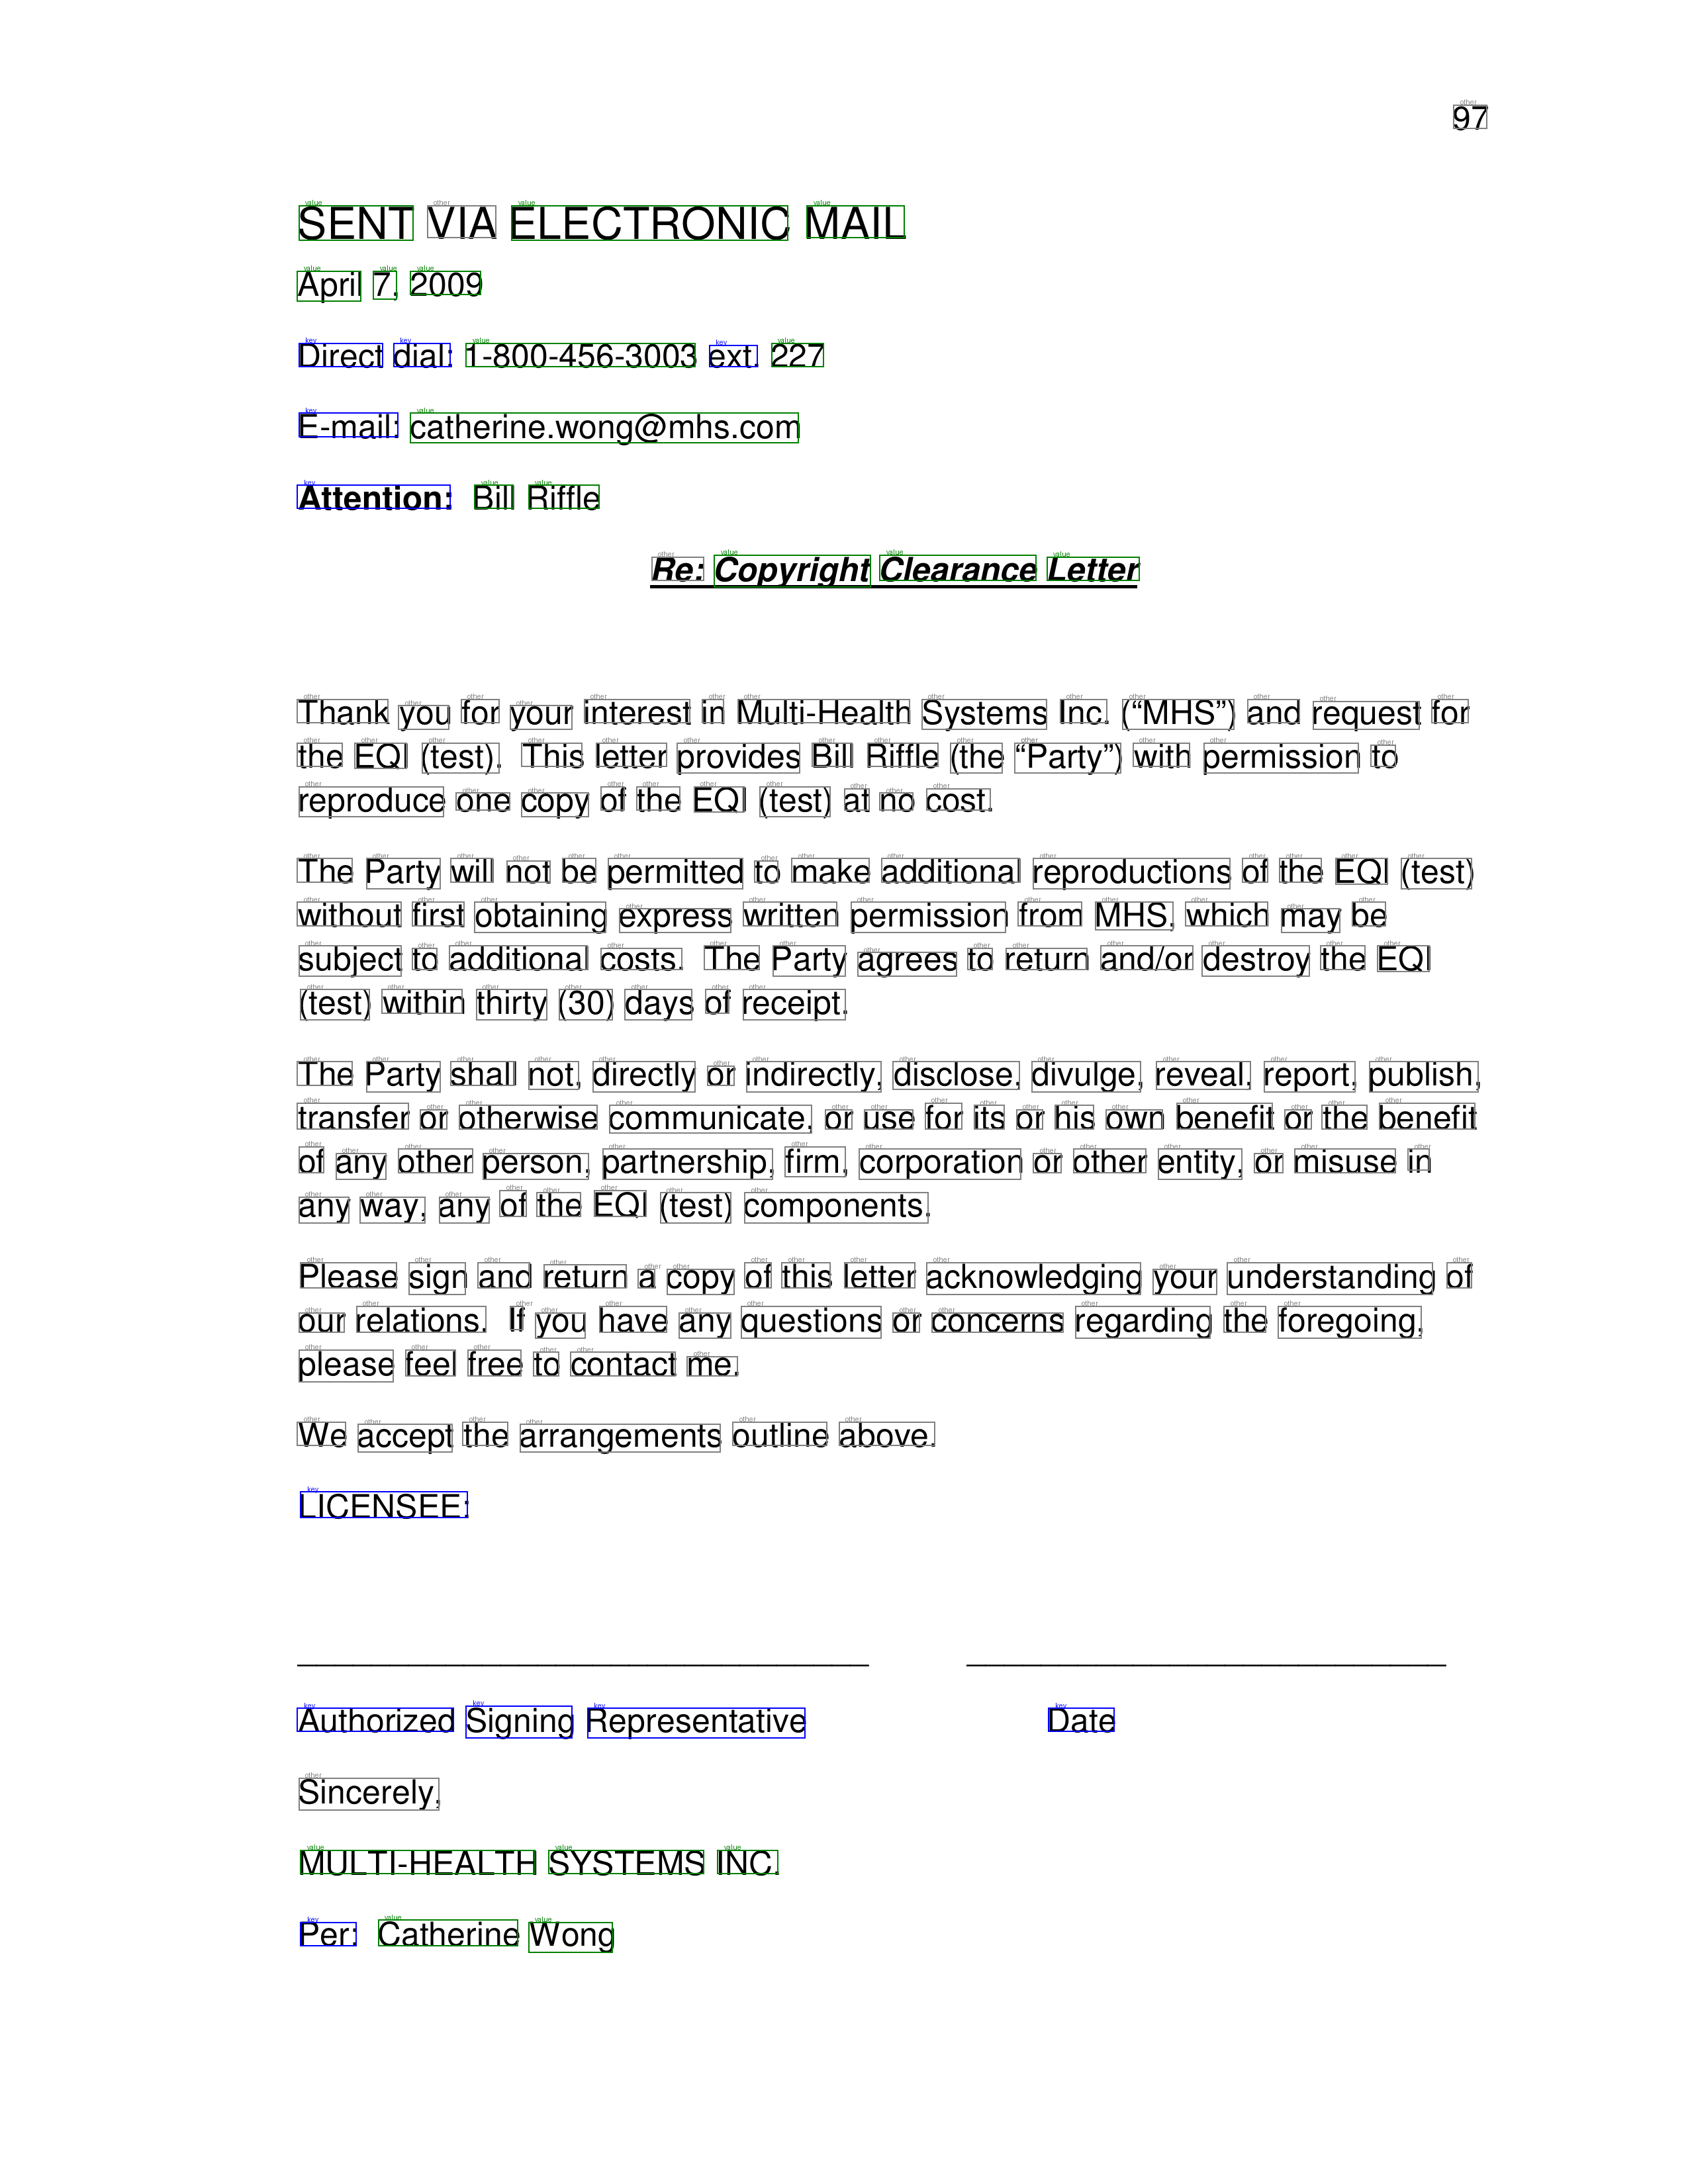

In [ ]:
from PIL import ImageDraw, ImageFont
from IPython.display import display

draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

for pred_label, box in zip(true_predictions, true_boxes):
    label = iob_to_label(pred_label)
    draw.rectangle(box, outline=label2color.get(label, "red"), width=2)
    draw.text((box[0] + 10, box[1] - 10), label, fill=label2color.get(label, "red"), font=font)

display(image)


_______
Ground truth

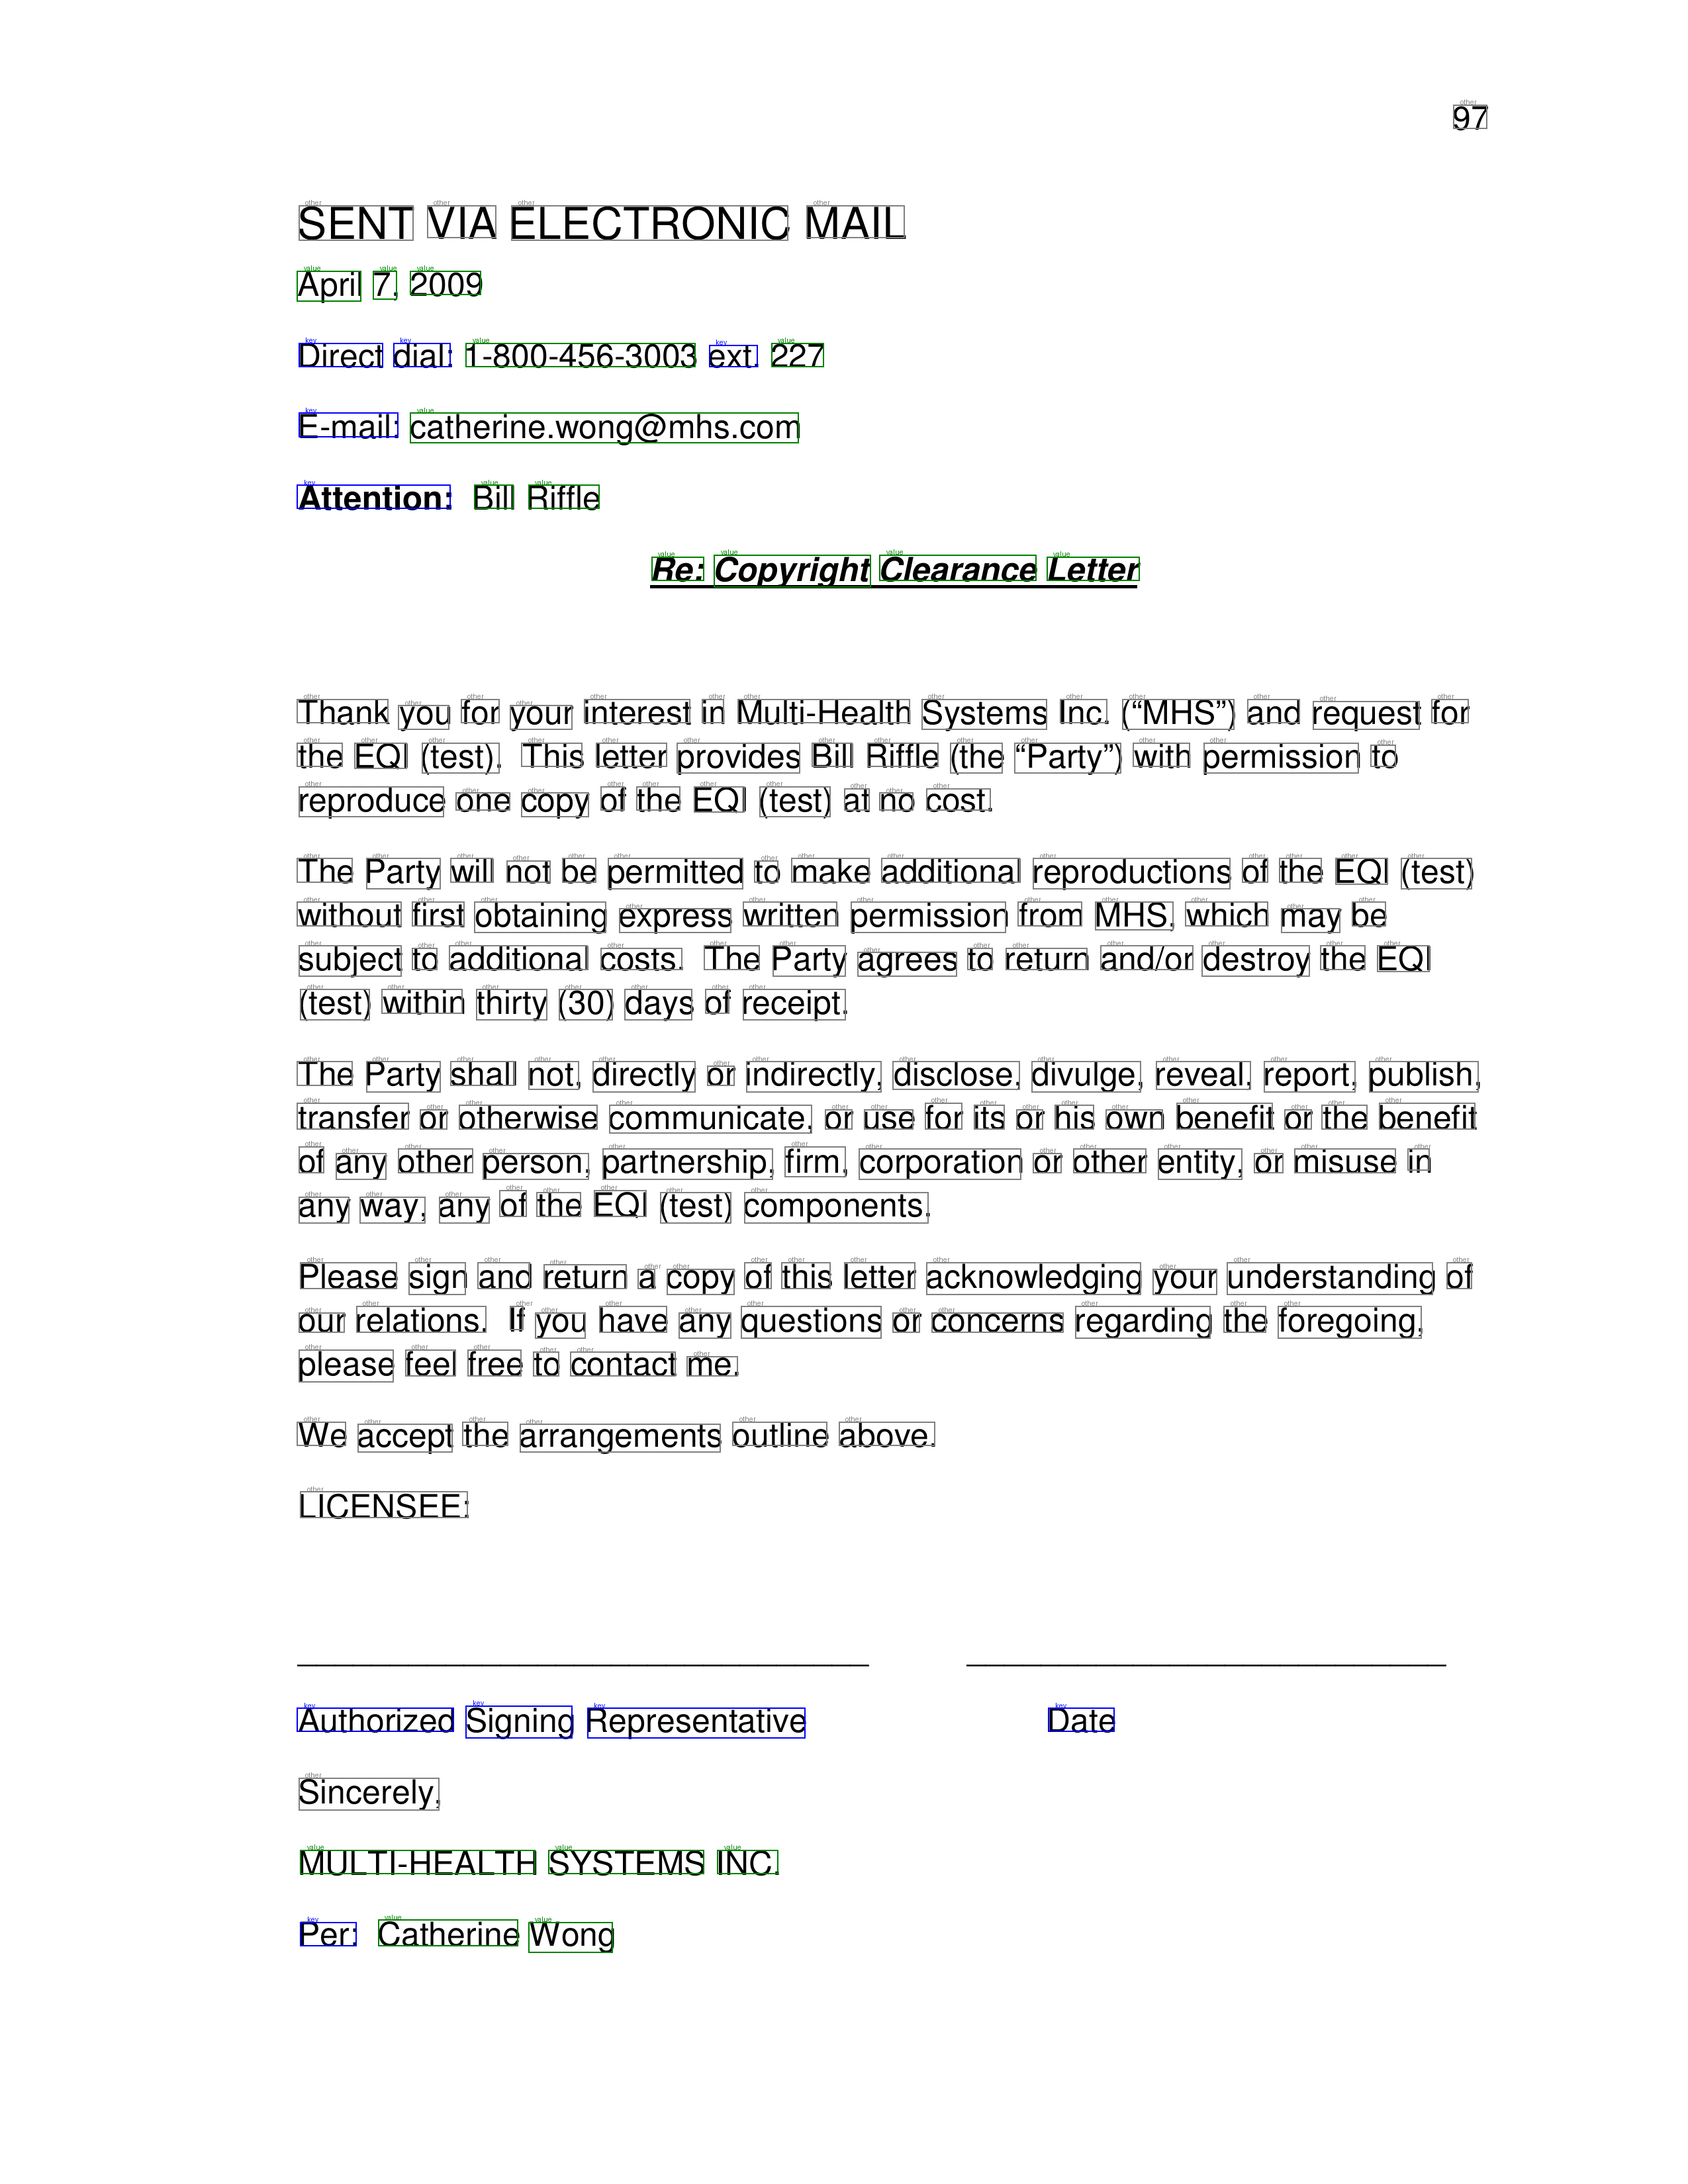

In [ ]:
image_true = example_raw["image"].convert("RGB")
draw_true = ImageDraw.Draw(image_true)

for word, box, label_id in zip(example_raw['tokens'], example_raw['bboxes'], example_raw['ner_tags']):
    label = iob_to_label(id2label[label_id]).lower()
    box = unnormalize_box(box, width, height)
    draw_true.rectangle(box, outline=label2color.get(label, "gray"), width=2)
    draw_true.text((box[0] + 10, box[1] - 10), label, fill=label2color.get(label, "gray"), font=font)

display(image_true)
